# Timeseries anomaly detection using an Autoencoder

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax, mean
import math
from numpy import arange, sin, pi, random
import tensorflow as tf
import keras
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from numpy import arange, sin, pi, random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.integrate as integrate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
import scipy as sp
from scipy.fft import fft, fftfreq
from scipy import signal

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None, xlabel='Time(ms)', ylabel='Value'):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def emg_fft(N, timeseries, Fs):
  high = 20/(Fs/2)
  low = 450/(Fs/2)
  b, a = sp.signal.butter(4, [high,low], btype='bandpass')
  # process EMG signal: filter EMG
  emg_filtered = sp.signal.filtfilt(b, a, timeseries)
  T = 1.0 / Fs
  x = np.linspace(0.0, N*T, N, endpoint=False)
  yf = fft(emg_filtered)
  xf = fftfreq(N, T)[:N//2]
  return xf, 2.0/N * np.abs(yf[0:N//2])

from sklearn.model_selection import train_test_split
def z_norm(result):
    result = np.array(result)
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean
def normalize(series):
    result = np.array(series)
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result
def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x sequence length x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)



def kde_sklearn(x, bandwidth=0.2, **kwargs):
	x_grid = np.linspace(x.min() - 0.9*x.min(), x.max() + x.max(), 500)
	"""Kernel Density Estimation with Scikit-learn"""
	kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
	kde_skl.fit(x[:, np.newaxis])
	# score_samples() returns the log-likelihood of the samples
	log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
	return np.exp(log_pdf), x_grid
   
def FindThreshold(x,h,p):
    tau=0
    x.sort() 
    for i in range(len(x)):
        int_K = integrate.quad(lambda s: (1/(h*np.sqrt(2*np.pi)))*np.exp(-0.5*(s-p)/h), (i-1)/len(x), i/len(x))
        tau=tau+int_K[0]*x[i]
    return tau

# **Prepare Data**

## Load the data


In [ ]:
path = "/content/gdrive/MyDrive/Đồ án 3/Data"
  
# Change the directory
os.chdir(path)  
n = len(os.listdir())
print(os.listdir())

['graphene type10 refAgCl (Lân).txt', 'graphene type 10 refGraphene snapbutton (Lân).txt', '20200520_18h35m_HongNhung_run.txt', '20201013_15h29m_Duc_back_nylon7_machTrongSleeve.txt', '20201013_17h09m_Duc_back_nylon7_machTruocBung.txt', 'Database-sEMG', 'Noise1_graphene.txt', 'Train_Valid_Loss.png', 'EMG_anomaly.png', 'plot.png', 'test.txt', '20201103_15h02m_KhacDu_agagcl_ecg_nguc.txt', 'test_noise2.txt']


<Figure size 432x288 with 0 Axes>

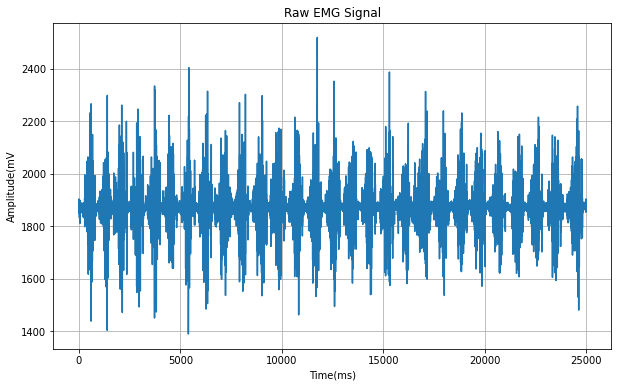

mean =  1867.24424
std =  62.12478367626241


In [ ]:
fs = 1000
dir = os.path.join(os.path.realpath(''),'/content/gdrive/MyDrive/Đồ án 3/Data/20200520_18h35m_HongNhung_run.txt')

emg_raw = []

with open(dir) as f:
    lines = f.readlines()
for l in lines:
    emg_raw.append(float(l.replace("\n","")))
emg_detrend = emg_raw - mean(emg_raw)
f = plt.figure()
time = range(0,25000)
training_signal = emg_raw[5600:(5600+25000)]
plt.figure(figsize=(10, 6))
plot_series(time,training_signal,ylabel='Amplitude(mV')
plt.title("Raw EMG Signal")
plt.show()
training_mean = mean(training_signal[0:25000])
training_std = std(training_signal[0:25000])
print("mean = ",training_mean)
print("std = ",training_std)


### Add noise

In [ ]:
"""
t = arange(0.0, 50.0, 0.1)
wave1 = 500*sin(2 * 0.5 * pi * t)
noise = random.normal(0, 100, len(t))
wave1 = wave1 + noise
print("wave1", len(wave1))
plt.plot(wave1)
np.savetxt('test.txt', wave1)
"""

'\nt = arange(0.0, 50.0, 0.1)\nwave1 = 500*sin(2 * 0.5 * pi * t)\nnoise = random.normal(0, 100, len(t))\nwave1 = wave1 + noise\nprint("wave1", len(wave1))\nplt.plot(wave1)\nnp.savetxt(\'test.txt\', wave1)\n'

noise2 500


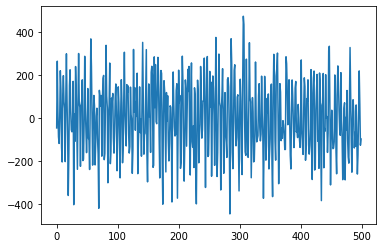

In [ ]:
t = arange(0.0, 50.0, 0.1)
wave1 = 200*sin(2 * 2 * pi * t)
noise = random.normal(0, 100, len(t))
noise2 = wave1 + noise
print("noise2", len(noise2))
plt.plot(noise2)
np.savetxt('test_noise2.txt', noise2)

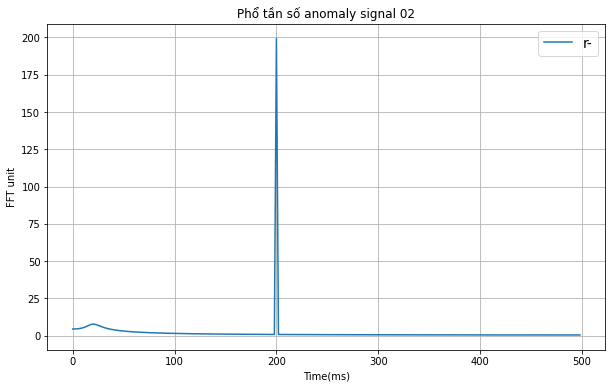

In [ ]:
afft, bfft = emg_fft(500,wave1,1000)
plt.figure(figsize=(10, 6))
plot_series(afft, bfft,ylabel='FFT unit',label='r-')
plt.title("Phổ tần số anomaly signal 02")
plt.show()

Text(0.5, 1.0, 'Tín hiệu ECG')

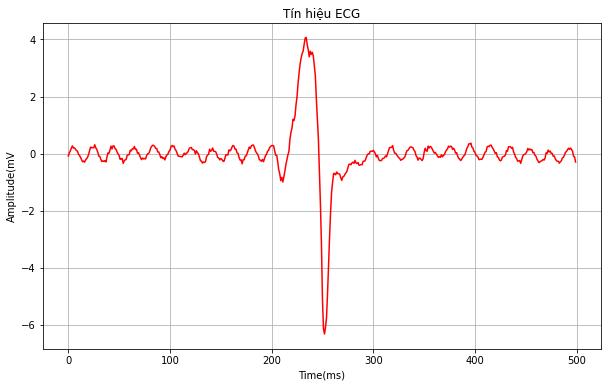

In [ ]:

noise_ecg = []

with open('20201103_15h02m_KhacDu_agagcl_ecg_nguc.txt') as f:
    lines = f.readlines()
for l in lines:
    noise_ecg.append(float(l.replace("\n",""))/2)
noise_ecg = normalize(noise_ecg[1200:1700])
tnoise = range(0,500)
plt.figure(figsize=(10,6))
plot_series(tnoise,noise_ecg, ylabel="Amplitude(mV", format='r-')
plt.title ("Tín hiệu ECG")

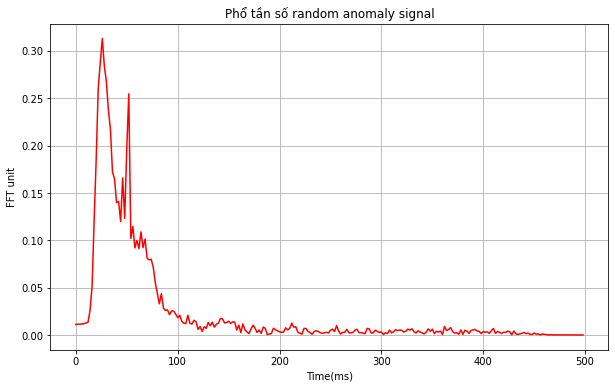

In [ ]:
xecgfft, yecgfft = emg_fft(500,noise_ecg,1000)
plt.figure(figsize=(10, 6))
plot_series(xecgfft, yecgfft,ylabel='FFT unit',format='r-')
plt.title("Phổ tần số random anomaly signal")
plt.show()

Giá trị nhỏ nhất Vnoise1_min =  -387.2238723769731 (mV)
Giá trị lớn nhất Vnoise1_max =  381.6498740193442 (mV)


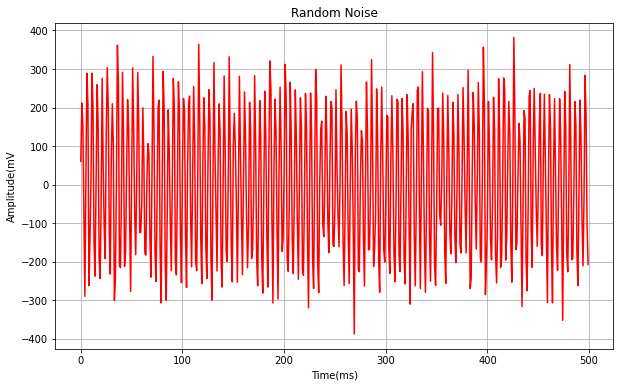

In [ ]:
noise2 = []

with open('test.txt') as f:
    lines = f.readlines()
for l in lines:
    noise2.append(float(l.replace("\n",""))/2)
#noise2 = (noise2)/training_std
tnoise = range(0,500)
plt.figure(figsize=(10,6))
plot_series(tnoise,noise2, ylabel="Amplitude(mV",format='r-')
plt.title("Random Noise")
print("Giá trị nhỏ nhất Vnoise1_min = ", min(noise2), "(mV)")
print("Giá trị lớn nhất Vnoise1_max = ", max(noise2), "(mV)")


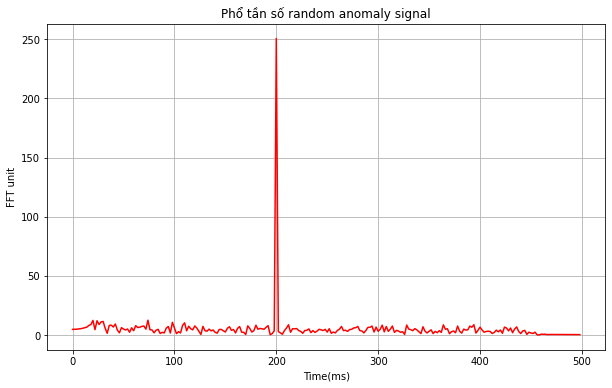

In [ ]:
xnoisefft, ynoisefft = emg_fft(500,noise2,1000)
plt.figure(figsize=(10, 6))
plot_series(xnoisefft, ynoisefft,ylabel='FFT unit',format='r-')
plt.title("Phổ tần số random anomaly signal")
plt.show()

<Figure size 432x288 with 0 Axes>

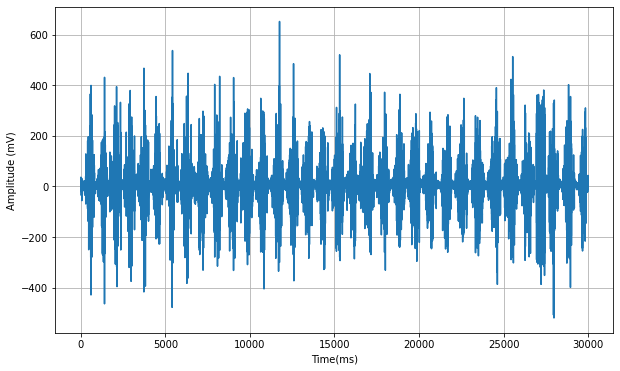

30001


In [ ]:
data = np.concatenate((np.array(emg_detrend[5600:32550]),noise2,np.array(emg_detrend[32551:35102])))
f = plt.figure()
plt.figure(figsize=(10, 6))
plot_series(range(0,30001),data, ylabel = 'Amplitude (mV)')
plt.show()
print(len(data))

## Create train & test set

-7.698123223932205
10.507171556549258


Text(0.5, 1.0, 'Normalized EMG signal')

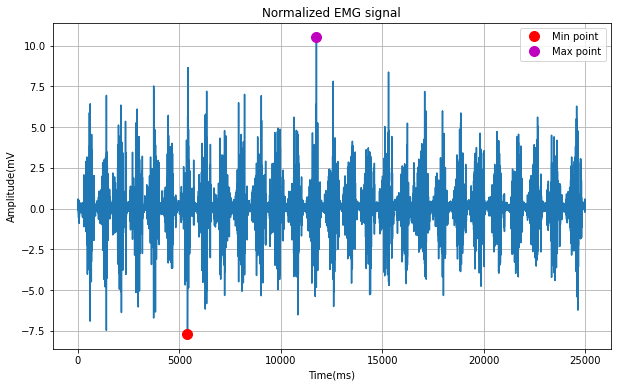

In [ ]:
time = range(0,25000)
emg_train = normalize(data[0:25000])
emg_test = normalize(data[25001:30001])
plt.figure(figsize=(10, 6))
plot_series(time,emg_train,ylabel='Amplitude(mV')
print(min(emg_train))
print(max(emg_train))
mark = [min(emg_train), max(emg_train)]
for i in time:
  if emg_train[i] == min(emg_train):
    red_dot, = plt.plot(i, emg_train[i], 'ro', markersize=10, label = 'Min value')
  if emg_train[i] == max(emg_train):
    purple_dot, = plt.plot(i, emg_train[i], 'mo', markersize=10, label = 'Max value')
plt.legend([red_dot, purple_dot], ["Min point", "Max point"])
plt.title("Normalized EMG signal")

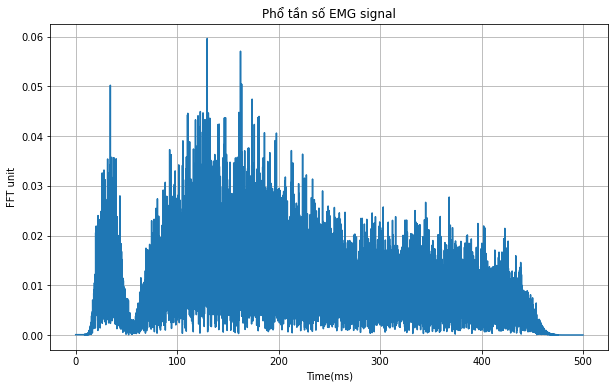

In [ ]:
xdatafft, ydatafft = emg_fft(25000, emg_train, 1000)
plt.figure(figsize=(10, 6))
plot_series(xdatafft, ydatafft,ylabel='FFT unit')
plt.title("Phổ tần số EMG signal")
plt.show()


In [ ]:
# train on first 7000 samples and test on next 3000 samples (has anomaly)
sequence_length = 100
DATA_SPLIT_PCT = 0.2
SEED = 123 #used to help randomly select the data points
batch_size = 128
epochs = 50

X_train,y_train, X_test, y_test = get_split_prep_data(0, 25000, 25001, 30001)
X_train, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, shuffle=False)
timesteps =  X_train.shape[1] # equal to the sequence_length
n_features =  X_train.shape[2] # 1
print('Features: ', n_features)
print('Timestep: ',timesteps)

Length of Data 30001
Creating train data...
Mean of train data :  0.018130390446983335
Train data shape  :  (24900, 100)
Creating test data...
Mean of test data :  0.15678041166900453
Test data shape  :  (4900, 100)
Shape X_train (24900, 99)
Shape X_test (4900, 99)
Features:  1
Timestep:  99


In [ ]:
len(emg_test)

5000

-4.633428218560854
4.562082252648291


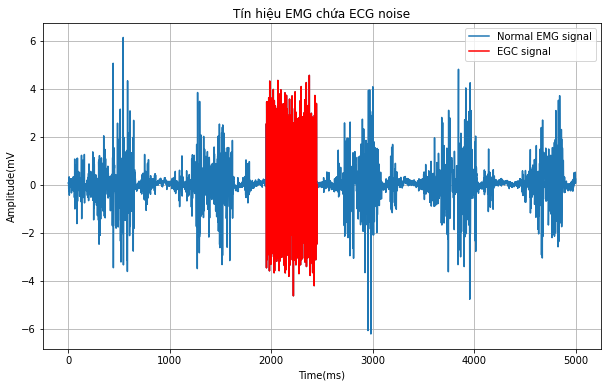

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(range(0,5000),emg_test,ylabel='Amplitude(mV', label = "Normal EMG signal")
plt.title("Tín hiệu EMG chứa ECG noise")
mark_noise = range(1950,2450)
plt.plot(mark_noise, emg_test[1950:2450],'r-',label = 'EGC signal')
print(min(emg_test[1950:2450]))
print(max(emg_test[1950:2450]))
plt.legend()

# **CNN - LSTM Model**

## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(RepeatVector(timesteps))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
#model.compile(loss='mse', optimizer='adam')
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
model.summary()
	# fit network



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 93, 64)            512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 87, 64)            28736     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 21, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1344)              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 99, 1344)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 99, 100)           578000    
_________________________________________________________________
time_distributed (TimeDistri (None, 99, 100)          

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "/content/gdrive/MyDrive/Đồ án 3/EMG-Signal-Processing/Model/conv_lstm_ae.h5", save_best_only=True)
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split = 0.1, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],)
model.save('/content/gdrive/MyDrive/Đồ án 3/EMG-Signal-Processing/Model/conv_lstm_ae.h5')

Epoch 1/50
176/176 [==============================] - 223s 1s/step - loss: 0.4126 - mae: 0.6710 - val_loss: 0.3149 - val_mae: 0.5678
Epoch 2/50
176/176 [==============================] - 218s 1s/step - loss: 0.3118 - mae: 0.5634 - val_loss: 0.2918 - val_mae: 0.5349
Epoch 3/50
176/176 [==============================] - 218s 1s/step - loss: 0.2844 - mae: 0.5178 - val_loss: 0.2838 - val_mae: 0.5195
Epoch 4/50
176/176 [==============================] - 218s 1s/step - loss: 0.2758 - mae: 0.5035 - val_loss: 0.2795 - val_mae: 0.5131
Epoch 5/50
176/176 [==============================] - 219s 1s/step - loss: 0.2726 - mae: 0.4990 - val_loss: 0.2718 - val_mae: 0.5053
Epoch 6/50
176/176 [==============================] - 218s 1s/step - loss: 0.2631 - mae: 0.4896 - val_loss: 0.2631 - val_mae: 0.4967
Epoch 7/50
176/176 [==============================] - 217s 1s/step - loss: 0.2579 - mae: 0.4849 - val_loss: 0.2585 - val_mae: 0.4975
Epoch 8/50
176/176 [==============================] - 216s 1s/step - 

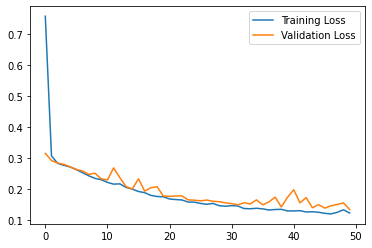

In [ ]:
fig = plt.figure()
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
#fig_name = "Train_Valid_Loss.png"
#fig.savefig(fig_name)

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


In [ ]:
model = keras.models.load_model("/content/gdrive/MyDrive/Đồ án 3/EMG-Signal-Processing/Model/conv_lstm_ae.h5")

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis=1)

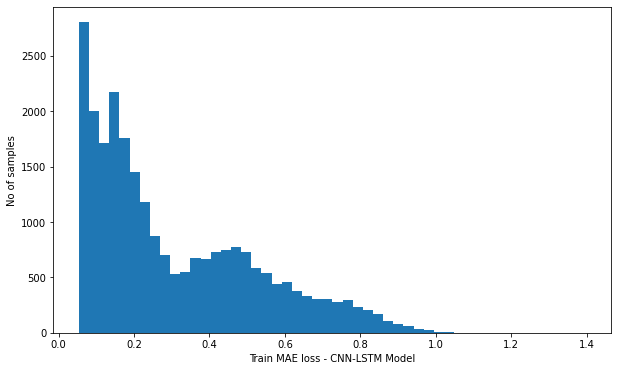

Reconstruction error threshold:  1.3985581682721282


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss - CNN-LSTM Model")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
np.min(train_mae_loss)

0.05353957361066691

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

Text(0.5, 1.0, 'Tín hiệu EMG gốc và tín hiệu EMG mô hình CNN-LSTM tạo dựng lại')

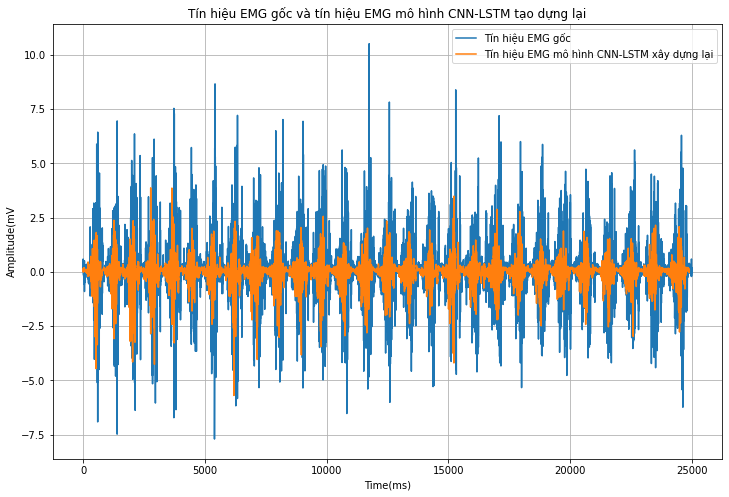

In [ ]:
emgtrained_pred = flatten(x_train_pred).flatten()
plt.figure(figsize=(12, 8))
plot_series(time,emg_train,ylabel='Amplitude(mV', label="Tín hiệu EMG gốc")
plot_series(range(0,len(emgtrained_pred)), emgtrained_pred, ylabel='Amplitude(mV', label='Tín hiệu EMG mô hình CNN-LSTM xây dựng lại')
plt.legend()
plt.title("Tín hiệu EMG gốc và tín hiệu EMG mô hình CNN-LSTM tạo dựng lại")

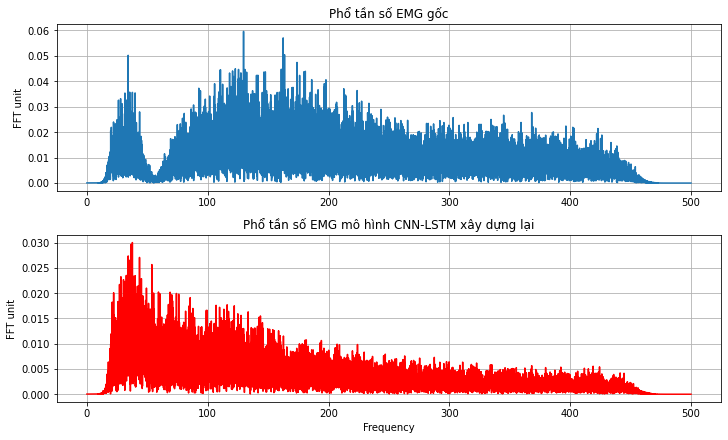

In [ ]:
emgtrained_pred = flatten(x_train_pred).flatten()
#plot_series(range(0,24900), emgtrained_pred)
Xfft, Yfft = emg_fft(24900, emgtrained_pred, 1000)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6))
axs[0].plot(xdatafft, ydatafft)
axs[0].set_title('Phổ tần số EMG gốc')
axs[0].set_ylabel('FFT unit')
axs[0].grid(True)
axs[1].plot(Xfft, Yfft, 'r-')
axs[1].set_title('Phổ tần số EMG mô hình CNN-LSTM xây dựng lại')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('FFT unit')
axs[1].grid(True)




### Prepare test data

Text(0.5, 1.0, 'Test Set')

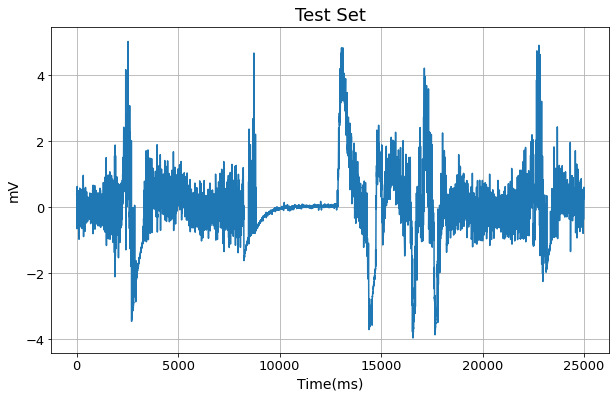

In [ ]:
dir = os.path.join(os.path.realpath(''),'/content/gdrive/MyDrive/Đồ án 3/Data/graphene_emg_test.txt')

emg_test = []

with open(dir) as f:
    lines = f.readlines()
for l in lines:
    emg_test.append(float(l.replace("\n","")))
emg_test_normalize = normalize(emg_test)
plt.figure(figsize=(10,6))
plt.rc('axes', titlesize=13)
plot_series(range(0,len(emg_test_normalize)),emg_test_normalize,ylabel="mV")
plt.title("Test Set",fontsize = 18)

In [ ]:
emg_test_seqs = []
print(timesteps)
def series_to_sequences (seqs, series, sequence_length):
  for index in range(0, len(series) - sequence_length):
        seqs.append(series[index: index + sequence_length])
series_to_sequences(emg_test_seqs, emg_test_normalize, timesteps+1)
emg_test_seqs = np.array(emg_test_seqs)
X_test = emg_test_seqs[:, :-1]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

99
(24900, 99, 1)


In [ ]:
# Get test MAE loss.
x_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(x_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

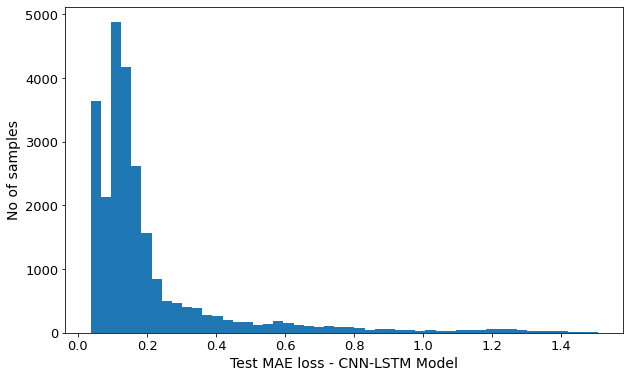

Number of anomaly samples:  599


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(test_mae_loss, bins=50)
plt.ylabel("No of samples")
plt.xlabel("Test MAE loss - CNN-LSTM Model")

plt.show()
threshold = 1.0
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
#print("Indices of anomaly samples: ", np.where(anomalies))


In [ ]:
print(test_mae_loss)
print(threshold)
anomalies = np.array(anomalies)
anomalies_index = []

for i in range(0,len(anomalies)):
  if anomalies[i] == True:
    anomalies_index.append(i + 100)

print(anomalies_index)


[0.09272818 0.08578714 0.09036082 ... 0.10318975 0.10139489 0.09538118]
1.0
[13022, 13023, 13024, 13025, 13026, 13027, 13028, 13029, 13030, 13031, 13032, 13033, 13034, 13035, 13036, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 13051, 13052, 13053, 13054, 13055, 13056, 13057, 13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095, 13096, 13097, 13098, 13099, 13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13119, 13120, 13121, 13122, 13123, 13124, 13125, 13126, 13127, 13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135, 13136, 13137, 13138, 13139, 13140, 13141, 13142, 13143, 13144, 13145, 13146, 13147, 13148, 13149, 13150, 13151, 13152, 13153,

Text(0.5, 1.0, 'EMG test và EMG test reconstructed by CNN-LSTM Model')

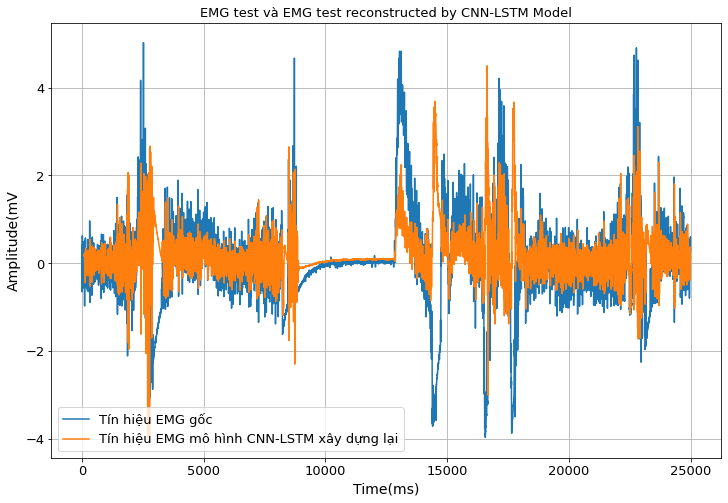

In [ ]:
emgtest_pred = flatten(x_test_pred).flatten()
plt.figure(figsize=(12, 8))
plot_series(range(0,len(emg_test)),emg_test_normalize,ylabel='Amplitude(mV', label="Tín hiệu EMG gốc")
plot_series(range(100,100+len(emgtest_pred)), emgtest_pred, ylabel='Amplitude(mV', label='Tín hiệu EMG mô hình CNN-LSTM xây dựng lại')
plt.legend()
plt.title('EMG test và EMG test reconstructed by CNN-LSTM Model')

## Plot anomalies

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

Let's overlay the anomalies on the original test data plot.

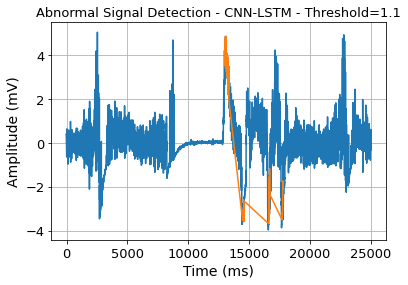

In [ ]:
import pandas as pd


plot_series(range(0,len(emg_test)),emg_test_normalize)
#for i in range(0,len(anomalies_index)):
#  plt.plot(anomalies_index[i],emg_test[anomalies_index[i]], marker = 'o', ms = 1, mec = 'r', mfc = 'r')
plt.plot(anomalies_index,emg_test_normalize[anomalies_index])
plt.title("Abnormal Signal Detection - CNN-LSTM - Threshold=1.1")
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mV)')
plt.show()





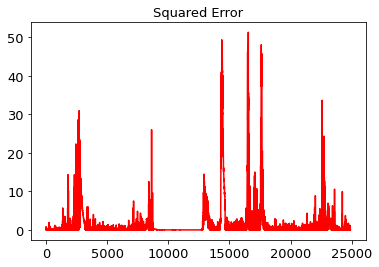

In [ ]:
plt.figure()
plt.title("Squared Error")
mse_ae = np.mean(np.power(flatten(X_test) - flatten(x_test_pred), 2), axis=1)
plt.plot(mse_ae, 'r')

# **LSTM Autoencoder Model**

## **Build Model**

In [ ]:

# build network
lstm_autoencoder = Sequential()
            # Encoder
lstm_autoencoder.add(LSTM(100, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
            # Decoder
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
#lstm_autoencoder.compile(optimizer='adam', loss='mae')
lstm_autoencoder.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
lstm_autoencoder.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 99, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 99, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 99, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 99, 1)             129       
Total params: 215,009
Trainable params: 215,009
Non-trainable params: 0
__________________________________________________

In [ ]:
lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch_size, 
                                                validation_split = 0.1,
                                                verbose=1, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]).history


lstm_autoencoder.save('/content/gdrive/MyDrive/Đồ án 3/EMG-Signal-Processing/Model/lstm_ae.h5')                                               
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Training Loss')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## **Reconstruction Evaluation**

In [ ]:
lstm_autoencoder = keras.models.load_model("/content/gdrive/MyDrive/Đồ án 3/EMG-Signal-Processing/Model/lstm_ae.h5")

In [ ]:
# Get train MAE loss.
xae_train_pred = lstm_autoencoder.predict(X_train)
trainae_mae_loss = np.mean(np.abs(xae_train_pred - X_train), axis=1)

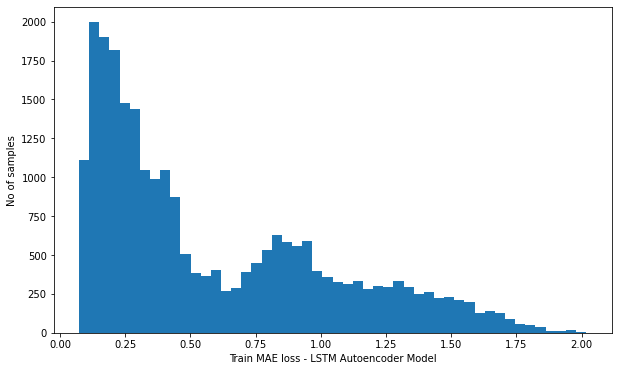

Reconstruction error threshold:  2.0177196644726307


In [ ]:
plt.figure(figsize=(10,6))
plt.hist(trainae_mae_loss, bins=50)
plt.xlabel("Train MAE loss - LSTM Autoencoder Model")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
thresholdae = np.max(trainae_mae_loss)
print("Reconstruction error threshold: ", thresholdae)

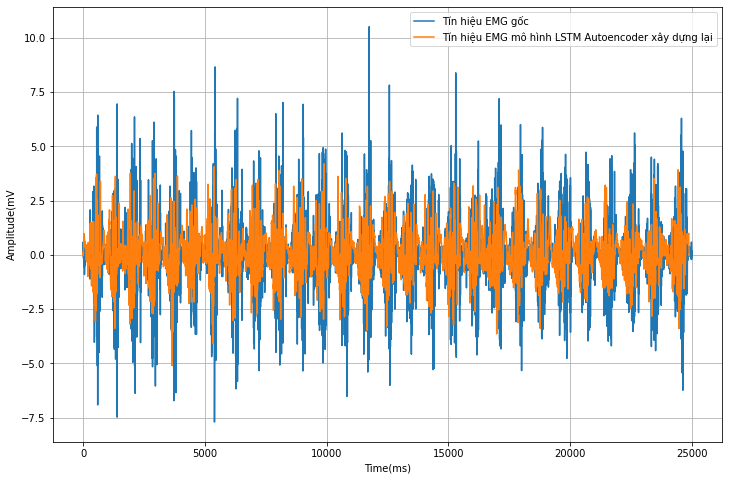

In [ ]:
emgtrainedae_pred = ((flatten(xae_train_pred).flatten()))*50
emgtrainedae_pred = normalize(emgtrainedae_pred)
plt.figure(figsize=(12, 8))
plot_series(time,emg_train,ylabel='Amplitude(mV', label="Tín hiệu EMG gốc")
plot_series(range(0,len(emgtrainedae_pred)), emgtrainedae_pred, ylabel='Amplitude(mV', label='Tín hiệu EMG mô hình LSTM Autoencoder xây dựng lại')
plt.legend()

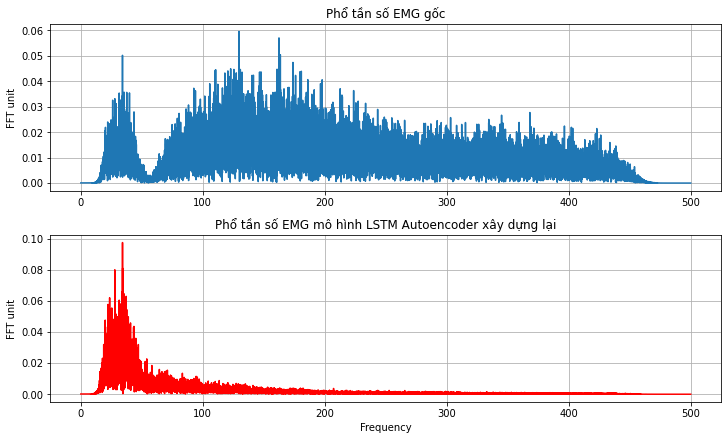

In [ ]:
Xaefft, Yaefft = emg_fft(24900, emgtrainedae_pred, 1000)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10, 6))
axs[0].plot(xdatafft, ydatafft)
axs[0].set_title('Phổ tần số EMG gốc')
axs[0].set_ylabel('FFT unit')
axs[0].grid(True)
axs[1].plot(Xaefft, Yaefft, 'r-')
axs[1].set_title('Phổ tần số EMG mô hình LSTM Autoencoder xây dựng lại')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('FFT unit')
axs[1].grid(True)

## Anomally Detection

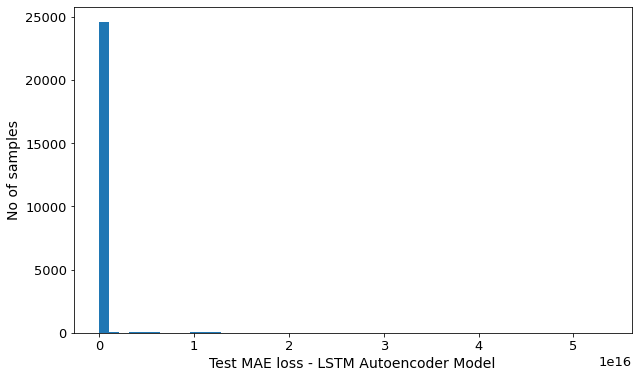

In [ ]:
xae_test_pred = lstm_autoencoder.predict(X_test)
testae_mae_loss = np.mean(np.abs(xae_test_pred - X_test), axis=1)
testae_mae_loss = testae_mae_loss.reshape((-1))

plt.figure(figsize=(10,6))
plt.hist(testae_mae_loss, bins=50)
plt.xlabel("Test MAE loss - LSTM Autoencoder Model")
plt.ylabel("No of samples")
plt.show()


24900


Text(0.5, 1.0, 'EMG test và EMG test reconstructed by LSTM-Ae Model')

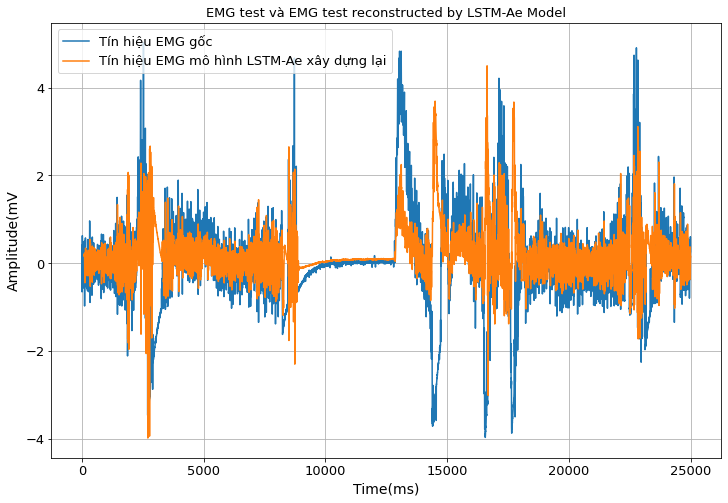

In [ ]:
emgtestae_pred = flatten(xae_test_pred).flatten()
print(len(emgtestae_pred))
plt.figure(figsize=(12, 8))
plot_series(range(0,len(emg_test)),emg_test_normalize,ylabel='Amplitude(mV', label="Tín hiệu EMG gốc")
plot_series(range(100,len(emg_test)), emgtest_pred, ylabel='Amplitude(mV', label='Tín hiệu EMG mô hình LSTM-Ae xây dựng lại')
plt.legend()
plt.title("EMG test và EMG test reconstructed by LSTM-Ae Model")

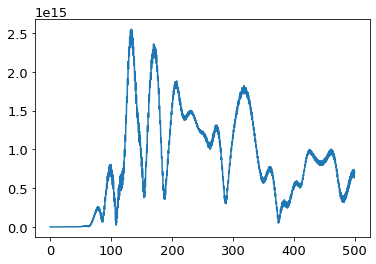

In [ ]:
Xaeprfft, Yaeprfft = emg_fft(4900, emgtestae_pred, 1000)
plt.plot(Xaeprfft, Yaeprfft )

In [ ]:
# Detect all the samples which are anomalies.
thresholdae = 1
anomalies_ae = testae_mae_loss > thresholdae
print("Number of anomaly samples: ", np.sum(anomalies_ae))
#print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  4230


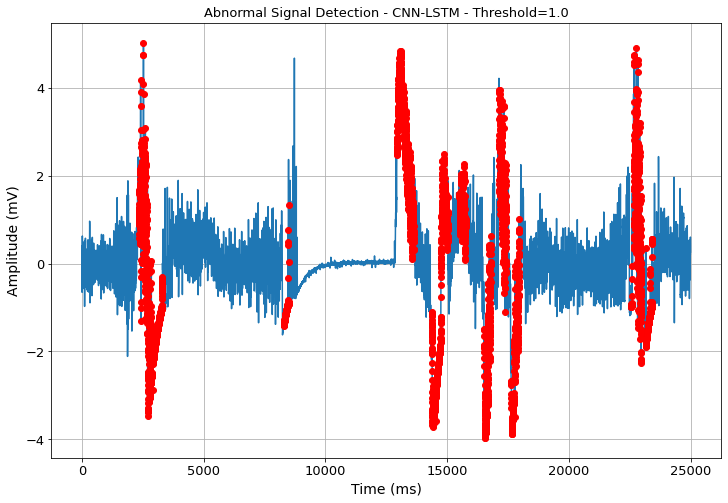

In [ ]:
import pandas as pd

anomalies_ae = np.array(anomalies_ae)
anomalies_ae_index = []

for i in range(0,len(anomalies_ae)):
  if anomalies_ae[i] == True:
    anomalies_ae_index.append(i+100)


fig, ax = plt.subplots(figsize=(12, 8))

plot_series(range(0,len(emg_test)),emg_test_normalize)
#for i in range(0,len(anomalies_index)):
#  plt.plot(anomalies_ae_index[i],emg_test_normalize[anomalies_ae_index[i]], marker = 'o', ms = 1, mec = 'r', mfc = 'r')
plt.plot(anomalies_ae_index,emg_test_normalize[anomalies_ae_index], 'o', color='red')
plt.title("Abnormal Signal Detection - CNN-LSTM - Threshold=1.0")
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (mV)')
plt.show()

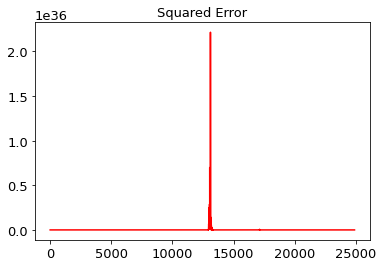

In [ ]:
plt.figure()
plt.title("Squared Error")
mse_ae = np.mean(np.power(flatten(X_test) - flatten(xae_test_pred), 2), axis=1)
plt.plot(mse_ae, 'r')